In [31]:
from nilearn import image as img
from nilearn import plotting as plot
from nilearn import surface
from nibabel.cifti2.cifti2 import Cifti2Image
import nibabel as nib
import numpy as np
import os
%matplotlib inline

In [57]:
# Try surface plotting module
sub = 'sub-NDAREU211JMY'
results_dir=f'../data/ciftify/{sub}/MNINonLinear/Results/task-rest_desc-preproc'
mni_dir = f'../data/ciftify/{sub}/MNINonLinear/fsaverage_LR32k/'
f_l_mt = f'{mni_dir}/{sub}.L.midthickness.32k_fs_LR.surf.gii'
f_r_mt = f'{mni_dir}/{sub}.R.midthickness.32k_fs_LR.surf.gii'
f_ct = f'{mni_dir}/{sub}.thickness.32k_fs_LR.dscalar.nii'
f_sulc = f'{mni_dir}/{sub}.sulc.32k_fs_LR.dscalar.nii'
f_volfunc = f'{results_dir}/task-rest_desc-preproc.nii.gz'
f_atlas = f'{mni_dir}/{sub}.L.atlasroi.32k_fs_LR.shape.gii'

In [33]:
def construct_cifti_surf_mesh(l,r):
    '''
    Given a left hemisphere nibabel object and
    right hemisphere nibabel object, construct
    a surface mesh array with coordinates and
    triangles.
    
    For now assume a natural ordering [LEFT,RIGHT]
    and use that to increment indexing
    '''
    
    cifti_coord = []
    cifti_trigs = []
    prev_max = 0
    for h in [l,r]:
        
        coords = l.darrays[0].data
        cifti_coord.append(coords)
        cifti_trigs.append(l.darrays[1].data + prev_max)
        prev_max = coords.shape[0]
        
    return (
        np.concatenate(cifti_coord, axis=0),
        np.concatenate(cifti_trigs, axis=0)
    )      

In [34]:
def construct_map_from_cifti(cifti):
    '''
    Given a nibabel Cifti2Image file that is of
    type dscalar. Construct the required arrays to
    visualize the data using nilearn's plot_surf or
    view_surf functions.
    '''
    
    vertvals = np.asanyarray(cifti.dataobj)[0]
    brain_models = list(cifti.header.get_index_map(1).brain_models)
    vertices = np.zeros(2 * brain_models[0].surface_number_of_vertices,
                       dtype=vertvals.dtype)
    
    prev_verts = 0
    for b in brain_models:
        inds2fill = np.array(b.vertex_indices) + prev_verts
        vertices[inds2fill] = vertvals[b.index_offset:
                                      b.index_offset + b.index_count]
        prev_verts = b.surface_number_of_vertices
    
    return vertices

In [63]:
l_atlas = nib.load(f_atlas)

In [65]:
l_atlas.darrays[0].data

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [6]:
l_mt = nib.load(f_l_mt)
r_mt = nib.load(f_r_mt)
coord, trigs = construct_cifti_surf_mesh(l_mt, r_mt)

In [53]:
l_mt.darrays[0].data

array([[ -7.4589906, -44.1408   ,  30.263689 ],
       [-21.195683 , -40.584503 ,  62.4083   ],
       [-50.507065 , -10.250708 ,  41.714237 ],
       ...,
       [-61.581406 , -41.190342 ,  -4.926479 ],
       [-60.22133  , -38.96715  ,  -4.160318 ],
       [-58.747513 , -40.324543 ,  -5.12269  ]], dtype=float32)

In [74]:
vertices = construct_map_from_cifti(nib.load(f_ct))   
sulc = -construct_map_from_cifti(nib.load(f_sulc))

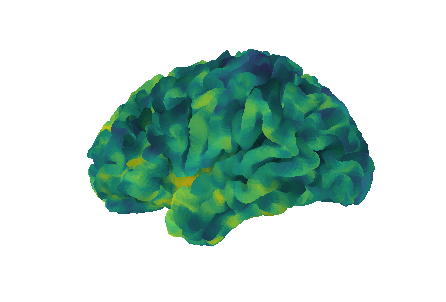

In [9]:
# Now perform the visualization!
k = plot.plot_surf(surf_mesh=[coord, trigs],
              surf_map = vertices,
              bg_map=sulc, bg_on_data=True,
              darkness=0.8,
              hemi='left')

In [35]:
volfunc_img = img.load_img(f_volfunc)

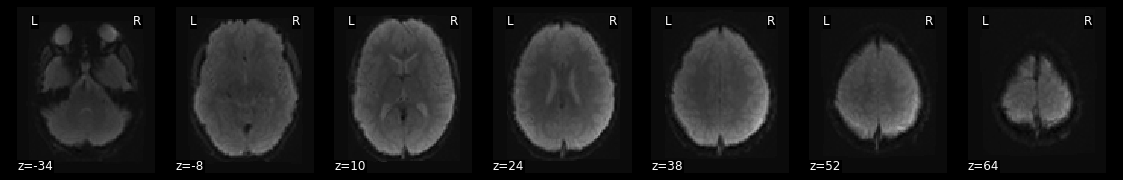

In [47]:
disp = plot.plot_anat(volfunc_img.slicer[:,:,:,0],
                    display_mode='z')

In [43]:
disp.savefig()